# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [3]:
!nvidia-smi

Wed Sep 16 13:57:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 54kB/s 


In [5]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [6]:
!pip install tqdm

In [7]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=59b1ec0f6443a956fc7683db1bc3f767f9a56f3084e0dcb35fc855a509e704b9
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=ff066b56b4528032acb50116d7b73761eb3c5e4ed8c38365a6cb4683459c140a
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=afffe527164b31e07dc8797418406e6a9e0a4675afcbe0996e6e2746dad0261a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [8]:
!pip install googletrans

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 962kB 8.2MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=026d3e08be281d3ef5c43cd8e36c455392898c3050a7aa2233c3643f31d94994
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=2d86dde986152f3d02f3f99f34e92413f95a875a34d127f58a8b1e4b91309110
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [9]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.7MB/s 


In [10]:
!pip install googletrans

In [11]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [12]:
# Hindi translated data
!gdown --id 1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw --output data-task1.csv

# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1zJVv_Ldh5vhDmw2mJSrgMcKlLt1fWyBw
To: /content/data-task1.csv
100% 797k/797k [00:00<00:00, 53.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 79.6MB/s]


In [13]:
orig_df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
orig_df.columns = ['Text', 'Label']
orig_df.head(15)
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [14]:
orig_df.Text[3]

"'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के गेट पर आधा नंगा होकर किया प्रदर्शन  पप्पू यादव ने बुलंद की\\xa0आवाज"

In [15]:
df = pd.read_csv('data-task1.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

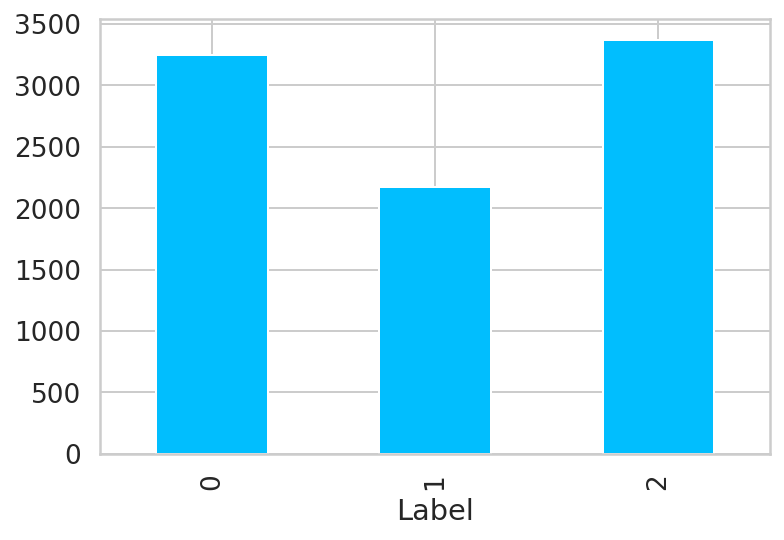

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [17]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3373
0    3245
1    2172
Name: Label, dtype: int64

In [18]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,"'@ kashaf512 what's the matter Subhan Allah, t...",1
1,'@Vithbheensui zindabad @ ashokgahlot51 @ asho...,0
2,@PremShuklaBJP @NewsNationTV @ DChaurasia2212 ...,2
3,'@iSinghApurva Jihadi your father is back,2
4,'@Drpremsaisingh @sagseikh @jobjacharya: Congr...,0
...,...,...
8785,"'Which country has that Surat e Ilahi settled,...",1
8786,'@mysandeepmishra NRC is required. Find the ji...,2
8787,"Happy Islamic New Year ""1442 Hijri"" to 'Alam-e...",1
8788,'@ NawabSufiyanAn2 Amen,1


Data Preprocessing

In [19]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [20]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [21]:
df = df[df.Text != '']

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [23]:
df=df.sample(frac=1).reset_index(drop=True)

In [24]:
df.head()

,Text,Label
0,Love Day Poet Jihadi Relief RIH,2
1,Nathuram Godse 6 Rajputmanish95 Rakesh Sinha ...,2
2,Population Control Kanun Zald Lagu What if no...,2
3,shufta20 Masha Allah Baji to remember in dua,1
4,Swwagatam Now Sushant Singh Rajput will be ch...,0


# Islamophhobia Detection with BERT


In [25]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-16 13:58:51--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   126MB/s    in 3.1s    

2020-09-16 13:58:54 (126 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [26]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [27]:
os.makedirs("model", exist_ok=True)

In [28]:
!mv uncased_L-12_H-768_A-12/ model

In [29]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [30]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [31]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [32]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [33]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7911it [00:04, 1948.18it/s]
879it [00:00, 2070.92it/s]


max seq_len 120


In [34]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcdaa365080> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [35]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 120)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 120, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [36]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
445/445 [==============================] - 226s 508ms/step - loss: 0.7420 - acc: 0.8045 - val_loss: 0.6395 - val_acc: 0.9066
Epoch 2/5
445/445 [==============================] - 223s 500ms/step - loss: 0.6235 - acc: 0.9265 - val_loss: 0.6236 - val_acc: 0.9306
Epoch 3/5
445/445 [==============================] - 222s 500ms/step - loss: 0.6070 - acc: 0.9435 - val_loss: 0.6254 - val_acc: 0.9230
Epoch 4/5
445/445 [==============================] - 223s 500ms/step - loss: 0.5968 - acc: 0.9541 - val_loss: 0.6185 - val_acc: 0.9331
Epoch 5/5
445/445 [==============================] - 222s 499ms/step - loss: 0.5889 - acc: 0.9624 - val_loss: 0.6120 - val_acc: 0.9407


## Evaluation

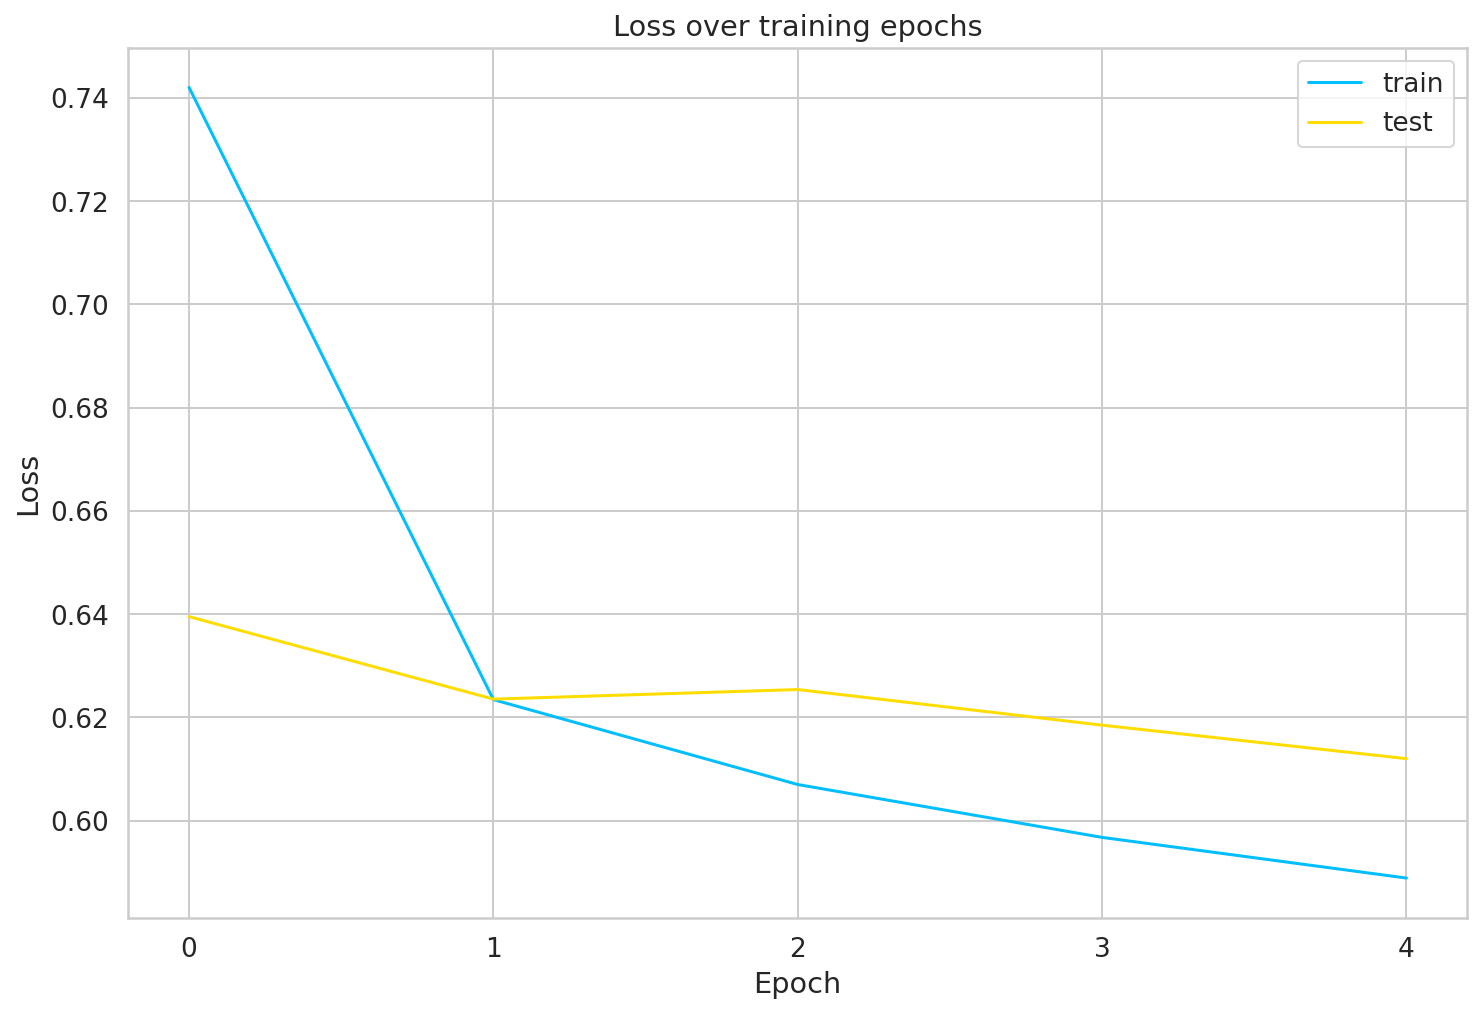

In [37]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

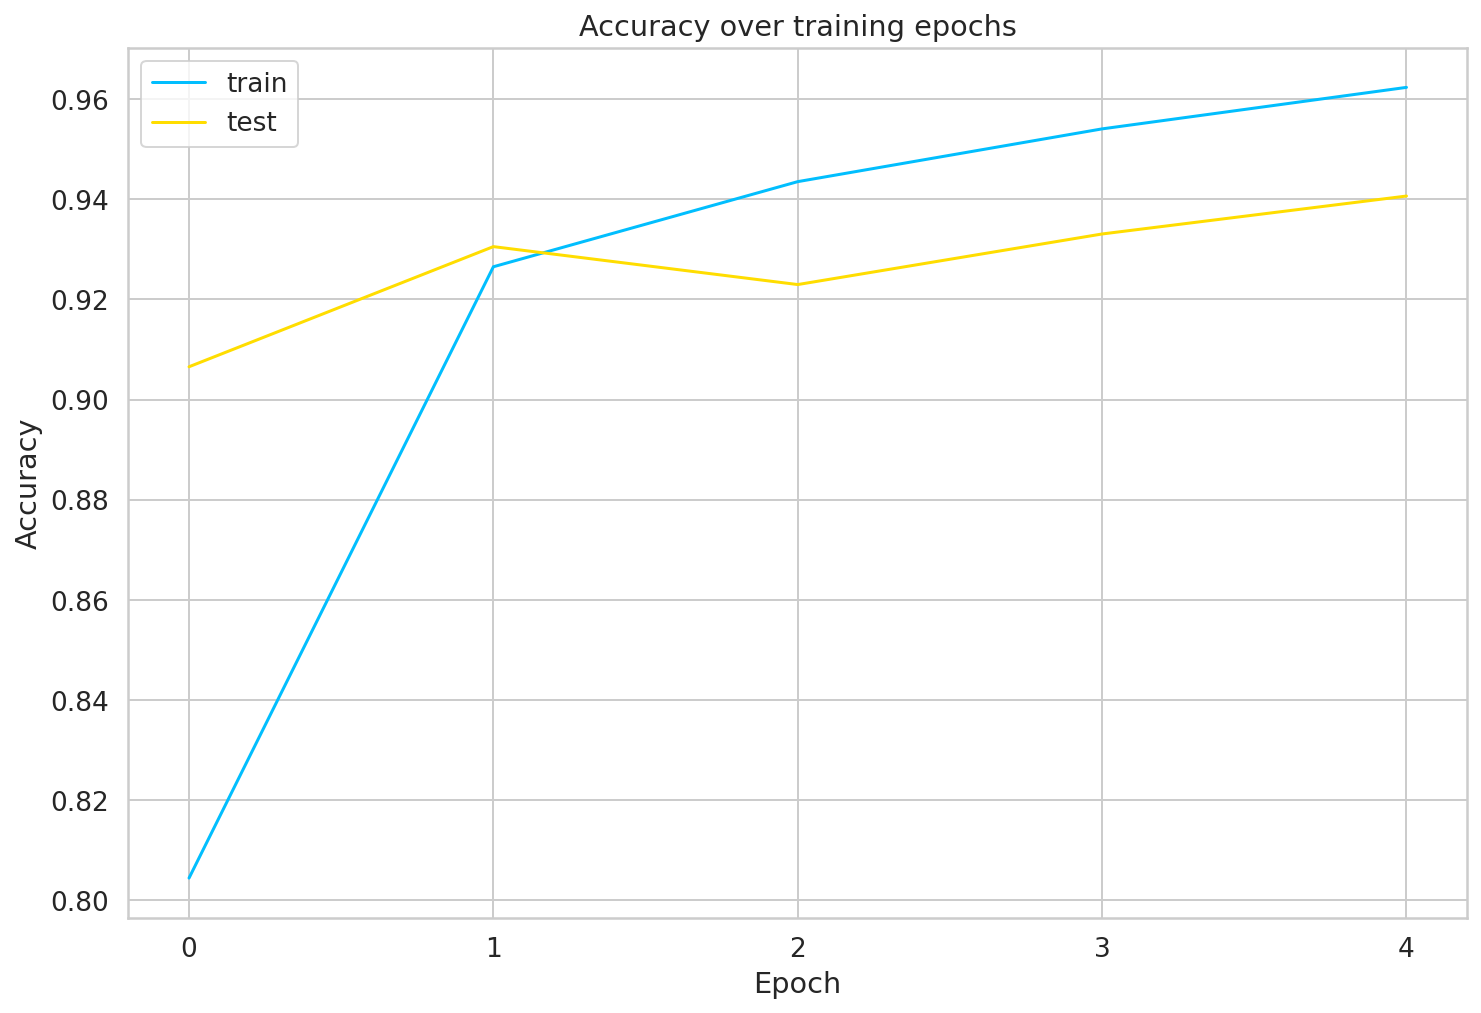

In [38]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [39]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

28/28 [==============================] - 5s 171ms/step - loss: 0.5999 - acc: 0.9511
train acc 0.9658703207969666
test acc 0.9510807991027832


In [40]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [41]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       301
           1       0.96      0.94      0.95       341
           2       0.95      0.95      0.95       237

    accuracy                           0.95       879
   macro avg       0.95      0.95      0.95       879
weighted avg       0.95      0.95      0.95       879



In [42]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

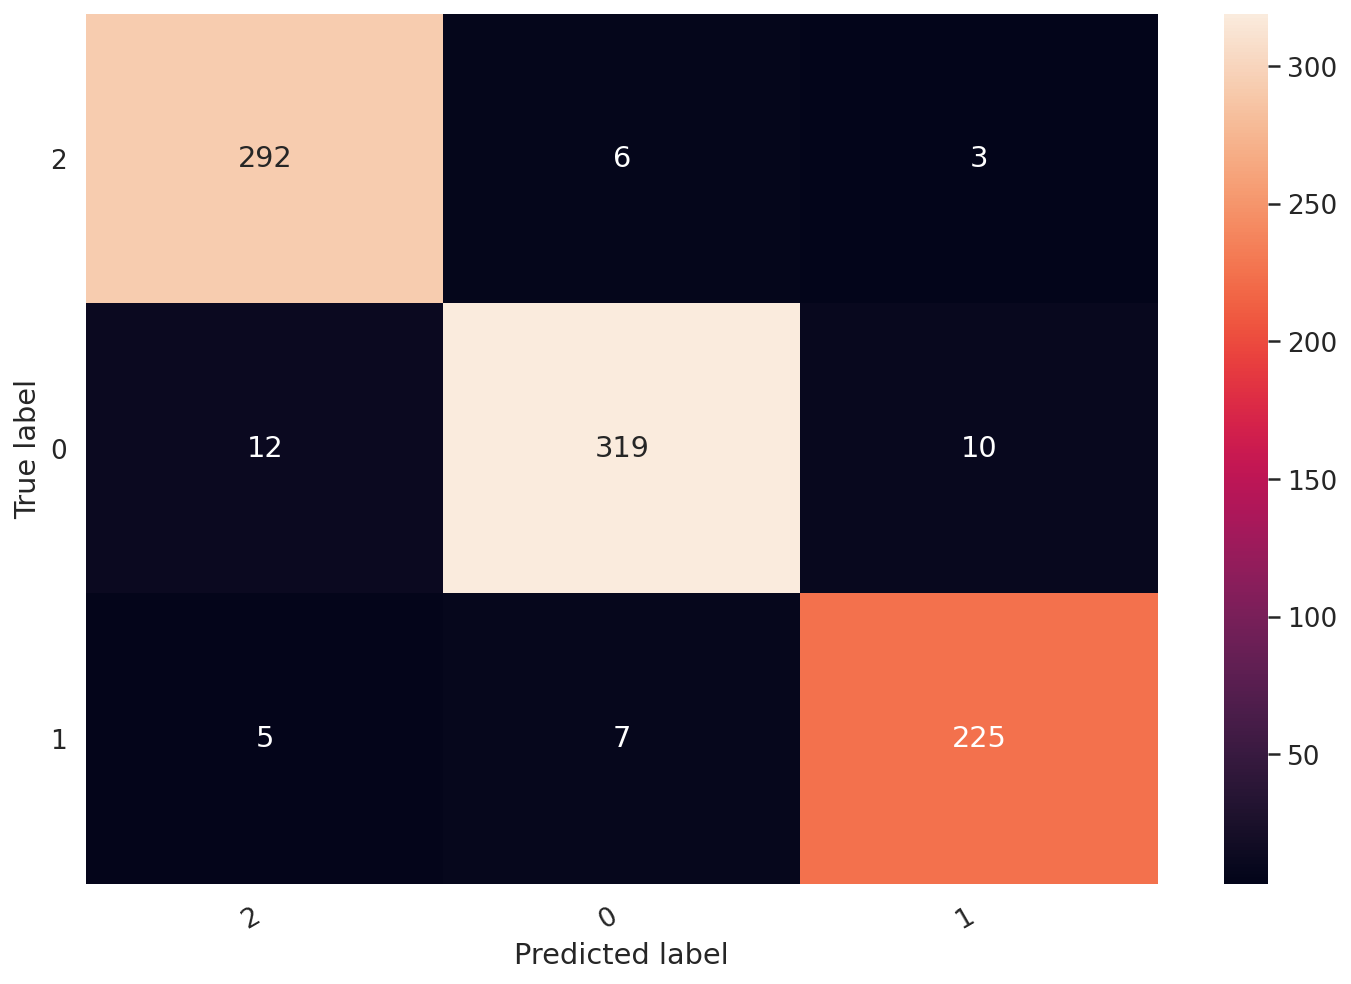

In [43]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [44]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


200it [00:00, 1987.87it/s]

BERT: 
Fold  1



7911it [00:03, 2017.32it/s]
879it [00:00, 2108.28it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcbb5a90dd8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 224s 503ms/step - loss: 0.8161 - acc: 0.7186 - val_loss: 0.6386 - val_acc: 0.9104
Epoch 2/5
445/445 [==============================] - 220s 495ms/step - loss: 0.6408 - acc: 0.9097 - val_loss: 0.6290 - val_acc: 0.9205
Epoch 3/5
445/445 [==============================] - 220s 494ms/step - loss

190it [00:00, 1895.28it/s]

Fold  2



7911it [00:03, 2053.26it/s]
879it [00:00, 2069.69it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcaadd4e7b8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 224s 504ms/step - loss: 0.7697 - acc: 0.7693 - val_loss: 0.6279 - val_acc: 0.9205
Epoch 2/5
445/445 [==============================] - 221s 497ms/step - loss: 0.6175 - acc: 0.9329 - val_loss: 0.6218 - val_acc: 0.9280
Epoch 3/5
445/445 [==============================] - 221s 496ms/step - loss

217it [00:00, 2158.32it/s]

Fold  3



7911it [00:03, 2061.01it/s]
879it [00:00, 2070.44it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fccd8b4c4e0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 224s 503ms/step - loss: 0.7462 - acc: 0.7986 - val_loss: 0.6216 - val_acc: 0.9293
Epoch 2/5
445/445 [==============================] - 219s 492ms/step - loss: 0.6252 - acc: 0.9244 - val_loss: 0.6143 - val_acc: 0.9356
Epoch 3/5
445/445 [==============================] - 219s 493ms/step - loss

181it [00:00, 1799.37it/s]

Fold  4



7911it [00:03, 2064.56it/s]
879it [00:00, 2094.36it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcbb7bc9128> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 223s 501ms/step - loss: 0.7432 - acc: 0.8014 - val_loss: 0.6316 - val_acc: 0.9167
Epoch 2/5
445/445 [==============================] - 219s 493ms/step - loss: 0.6234 - acc: 0.9258 - val_loss: 0.6084 - val_acc: 0.9381
Epoch 3/5
445/445 [==============================] - 220s 494ms/step - loss

205it [00:00, 2045.14it/s]

Fold  5



7911it [00:03, 2046.09it/s]
879it [00:00, 2061.48it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fccd87ad908> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 224s 504ms/step - loss: 0.7199 - acc: 0.8275 - val_loss: 0.6405 - val_acc: 0.9078
Epoch 2/5
445/445 [==============================] - 221s 497ms/step - loss: 0.6181 - acc: 0.9326 - val_loss: 0.6325 - val_acc: 0.9154
Epoch 3/5
445/445 [==============================] - 220s 495ms/step - loss

173it [00:00, 1728.48it/s]

Fold  6



7911it [00:03, 2049.86it/s]
879it [00:00, 2077.48it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcbaef2de48> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 225s 505ms/step - loss: 0.7462 - acc: 0.7977 - val_loss: 0.6233 - val_acc: 0.9242
Epoch 2/5
445/445 [==============================] - 221s 497ms/step - loss: 0.6221 - acc: 0.9279 - val_loss: 0.6212 - val_acc: 0.9306
Epoch 3/5
445/445 [==============================] - 221s 497ms/step - loss

192it [00:00, 1915.61it/s]

Fold  7



7911it [00:03, 2010.64it/s]
879it [00:00, 2055.49it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fccd8bb40b8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 225s 506ms/step - loss: 0.7533 - acc: 0.7862 - val_loss: 0.6179 - val_acc: 0.9331
Epoch 2/5
445/445 [==============================] - 222s 498ms/step - loss: 0.6256 - acc: 0.9237 - val_loss: 0.6120 - val_acc: 0.9369
Epoch 3/5
445/445 [==============================] - 221s 498ms/step - loss

175it [00:00, 1739.86it/s]

Fold  8



7911it [00:03, 2050.39it/s]
879it [00:00, 2058.59it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcaad70aba8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 226s 507ms/step - loss: 0.7191 - acc: 0.8271 - val_loss: 0.6236 - val_acc: 0.9268
Epoch 2/5
445/445 [==============================] - 222s 499ms/step - loss: 0.6221 - acc: 0.9270 - val_loss: 0.6116 - val_acc: 0.9381
Epoch 3/5
445/445 [==============================] - 222s 498ms/step - loss

203it [00:00, 2019.21it/s]

Fold  9



7911it [00:03, 2095.24it/s]
879it [00:00, 2167.07it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fccda693eb8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 226s 508ms/step - loss: 0.7241 - acc: 0.8226 - val_loss: 0.6262 - val_acc: 0.9242
Epoch 2/5
445/445 [==============================] - 223s 501ms/step - loss: 0.6186 - acc: 0.9319 - val_loss: 0.6326 - val_acc: 0.9154
Epoch 3/5
445/445 [==============================] - 223s 500ms/step - loss

213it [00:00, 2124.01it/s]

Fold  10



7911it [00:03, 2046.10it/s]
879it [00:00, 2102.77it/s]


max seq_len 120
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcaadf7b860> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
445/445 [==============================] - 225s 505ms/step - loss: 0.7329 - acc: 0.8122 - val_loss: 0.6493 - val_acc: 0.8977
Epoch 2/5
445/445 [==============================] - 221s 496ms/step - loss: 0.6272 - acc: 0.9227 - val_loss: 0.6086 - val_acc: 0.9394
Epoch 3/5
445/445 [==============================] - 222s 498ms/step - loss

In [45]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9382252559726961
 Mean testing accuracy for 10 folds: 0.938225257396698


In [46]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful
Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 0

